## Modelling and inversion of a fault zone
This example was taken from a book chapter (Tanner et al. 2020) illustrating how ERT works using a hypothetical fault structure.

Tanner, D.C., Buness, H., Igel, J., Günther, T., Gabriel, G., Skiba, P., Plenefisch, T., Gestermann, N. & Walter, T. (2020): Fault Detection. in: Tanner, C.D. & Brandes, C. (Eds.): Understanding Faults, 380p., Elsevier, p. 81-146, doi:10.1016/B978-0-12-815985-9.00003-5.

In [25]:
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert

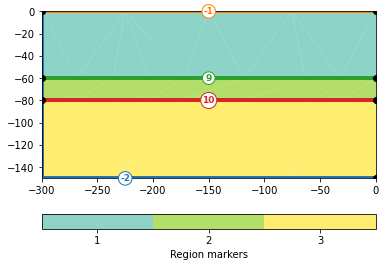

In [26]:
left = mt.createWorld(start=[-300, -150], end=[0, 0], layers=[-60, -80])
for b in left.boundaries():
    if b.center().x() == 0:
        b.setMarker(0)

pg.viewer.showMesh(left, markers=True, showBoundary=True);

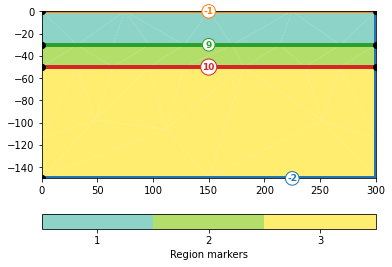

In [27]:
right = mt.createWorld(start=[0, -150], end=[300, 0], layers=[-30, -50])
for b in right.boundaries():
    if b.center().x() == 0:
        b.setMarker(0)

pg.viewer.showMesh(right, markers=True, showBoundary=True);

In [62]:
scheme = ert.createData(range(-200, 201, 25), 'dd')
print(scheme)

Data: Electrodes: 17 data: 105


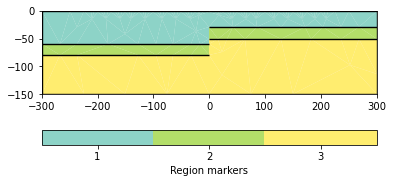

In [63]:
world = mt.mergePLC([left, right])
for pos in scheme.sensorPositions():
    world.createNode(pos, marker=-99)
    world.createNode(pos+pg.Pos(0, -3))
    
pg.show(world);

Mesh: Nodes: 732 Cells: 1308 Boundaries: 2039


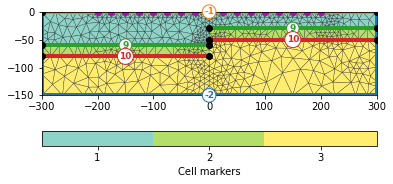

In [64]:
mesh = mt.createMesh(world, quality=34.6)
print(mesh)
ax, _ = pg.show(mesh, markers=True, showMesh=True)
ax.plot(pg.x(scheme), pg.y(scheme), 'mo');

Data error estimate (min:max)  0.03000447799494406 : 0.08054755434322698


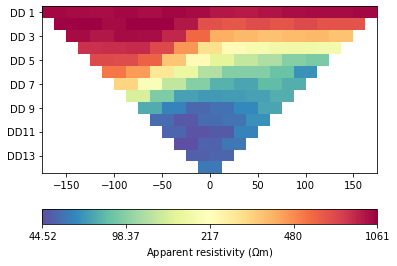

In [67]:
rhomap = [[1, 1000], [2, 10], [3, 100]]
data = ert.simulate(mesh, scheme, rhomap, noiseLevel=0.03, noiseAbs=10e-6)
pg.show(data);

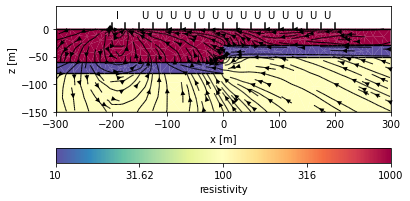

In [69]:
MAT = ert.simulate(mesh, scheme, rhomap, calcOnly=True, returnFields=True)
pot = MAT[1] - MAT[0]
ax, cb = pg.show(mesh, rhomap, logScale=True,
                 cMap='Spectral_r', label='resistivity')
ax.set_ylim(-150, 40)
pg.viewer.mpl.drawStreams(ax, mesh, pot)
# pg.mplviewer.drawMeshBoundaries(ax, world)
ax.set_xlabel('x [m]')
ax.set_ylabel('z [m]')
# draw electrode positions
ax.text(-190, 15, 'I', ha='center', va='bottom')
for xi in pg.x(data.sensorPositions()):
    ax.plot([xi, xi], [0, 10], 'k-')
    if xi < 200 and xi > -160:
        ax.text(xi+10, 15, 'U', ha='center', va='bottom')

# ax.figure.savefig('fault-rescurrent.pdf', bbox_inches='tight')

In [70]:
res = pg.solver.parseMapToCellArray(rhomap, mesh)
# pg.show(mesh, res, showMesh=True); # would do the same

In [71]:
mm = pg.Mesh(mesh)
for c in mm.cells():
    c.setMarker(1)

# bigMesh = pg.meshtools.appendTriangleBoundary(mesh, marker=0)
# mgr = ert.ERTManager(data)
mgr = ert.ERTManager()
mgr.setData(data)
mgr.setMesh(mm)
# mgr.mesh = mm
# mgr.fop.region(0).setBackground(True)
# resBig = pg.solver.parseMapToCellArray(rhomap, mesh)
mgr.fop.createJacobian(res)
j0 = mgr.fop.jacobian()[0]
print(mgr.paraDomain, len(j0))

26/11/21 - 21:48:32 - pyGIMLi - INFO - Found 1 regions.
26/11/21 - 21:48:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
26/11/21 - 21:48:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Mesh: Nodes: 732 Cells: 1308 Boundaries: 2039 1308


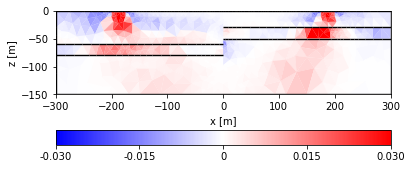

In [72]:
j1 = mgr.fop.jacobian()[-1] * res / data('rhoa')[data.size()-1]
cmax = 0.03
aS, _ = pg.show(mesh, j1, cMap='bwr', cMin=-cmax, cMax=cmax,
                xlabel='x [m]', ylabel='z [m]')#, label='sensitivity')
# aS.figure.savefig('fault-sens.pdf', bbox_inches='tight')

In [73]:
mgr = ert.ERTManager()
mgr.setData(data)
mgr.invert(zWeight=0.1, paraDX=0.1)

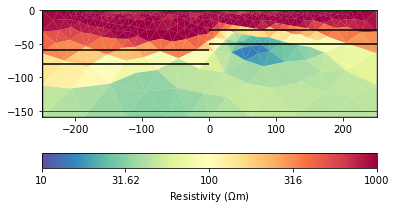

In [74]:
aR, _ = mgr.showResult(cMin=10, cMax=1000, cMap='Spectral_r')
pg.viewer.mpl.drawMeshBoundaries(aR, world, hideMesh=True, fitView=False, 
                                 linewidth=0.1, xlabel='x [m]', ylabel='z [m]')
äaR.figure.savefig('fault-res.pdf', bbox_inches='tight')